In [1]:
#@title Import Library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
import seaborn as sns
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
from google.colab import drive

In [2]:
#@title Import Google Drive Data
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Read CSV File And Directories
base_bone_dir = os.path.join('drive/MyDrive/BA_Data/Dr_Sabeti/')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'DigitalHandAtlas/Digital-Hand-Atlas-Train.csv'))
dir,folder,fi = next(os.walk(base_bone_dir+'DigitalHandAtlas/JPEGimages/'))
for i in range(len(folder)):
  dir,folder2,fi = next(os.walk(base_bone_dir+'DigitalHandAtlas/JPEGimages/'+folder[i]+'/'))
  for j in range(len(folder2)):
    dir,folder3,fi = next(os.walk(base_bone_dir+'DigitalHandAtlas/JPEGimages/'+folder[i]+'/'+folder2[j]+'/'))
    for k in range(len(fi)):
      age_df['path'] = os.path.join(base_bone_dir, 'DigitalHandAtlas/JPEGimages/'+folder[i]+'/'+folder2[j]+'/',fi[k])
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 1 if x else 0)
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
# we don't want normalization for now
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x - boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

1391 images found of 1391 total


,id,boneage,male,location,path,exists,gender,boneage_zscore
1222,5598,28,True,Hispanic,drive/MyDrive/BA_Data/Dr_Sabeti/DigitalHandAtl...,True,1,-0.886577
793,7150,153,False,Caucasian,drive/MyDrive/BA_Data/Dr_Sabeti/DigitalHandAtl...,True,0,0.190373
1133,5765,149,False,Hispanic,drive/MyDrive/BA_Data/Dr_Sabeti/DigitalHandAtl...,True,0,0.155911


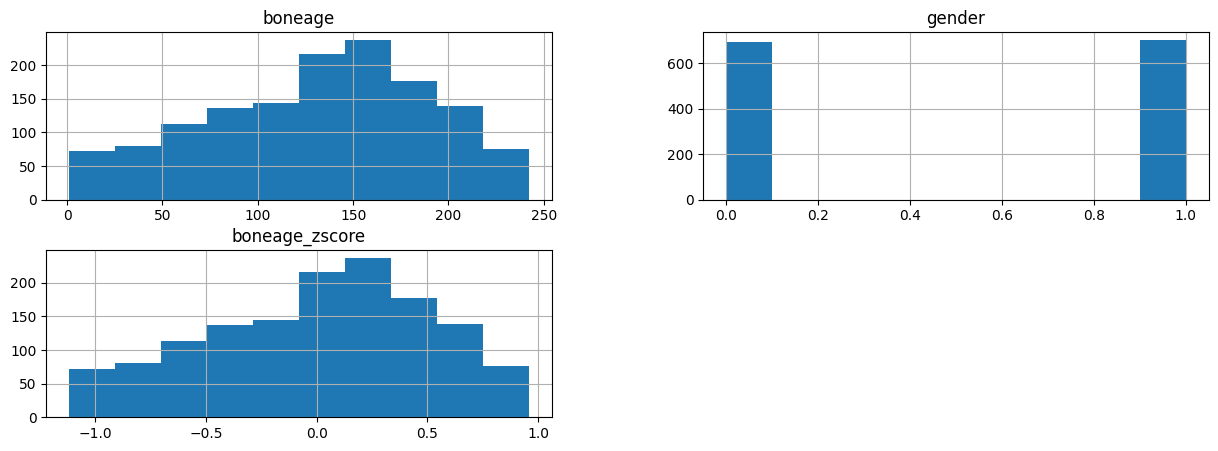

In [4]:
#@title Plot Data
age_df[['boneage','gender','boneage_zscore']].hist(figsize = (15, 5))
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)

In [5]:
#@title Split Train Data From Validation
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(age_df, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = age_df['boneage_category'])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 1112 validation 279


New Data Size: 10000 Old Size: 1112


array([[<Axes: title={'center': 'boneage'}>,
        <Axes: title={'center': 'gender'}>]], dtype=object)

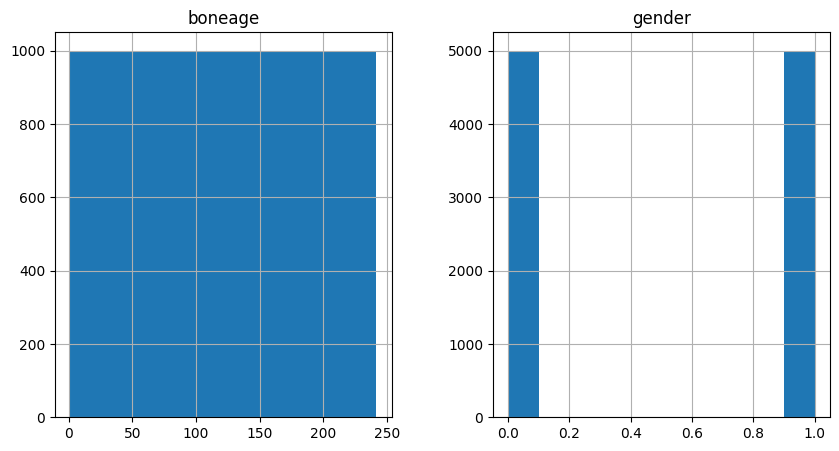

In [6]:
#@title Plot Train Data
train_df = raw_train_df.groupby(['boneage_category', 'gender']).apply(lambda x: x.sample(500, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['boneage', 'gender']].hist(figsize = (10, 5))

<Axes: xlabel='gender', ylabel='boneage'>

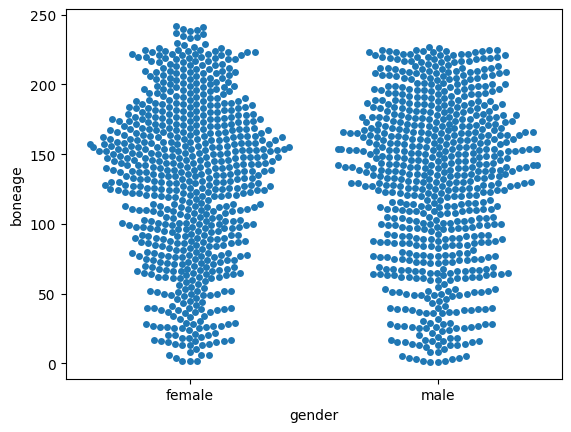

In [7]:
#Relationship between age and gender with a categorical scatter plot (swarmplot)
sns.swarmplot(x = age_df['gender'].map(lambda x: 'male' if x else 'female'), y = age_df['boneage'])

In [8]:
#@title Crop Images
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
IMG_SIZE = (220, 220) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.25,
                             preprocessing_function = preprocess_input)

In [9]:
#@title Image Augmentation
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = 'drive/MyDrive/BA_Data/Dr_Sabeti/DigitalHandAtlas/JPEGimages/'
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [10]:
#@title Flow_from_dataframe
train_gen = flow_from_dataframe(core_idg, raw_train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) 
# we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 1024)) 
# one big batch

## Ignore next message from keras, values are replaced anyways
Found 1286 images belonging to 8 classes.
Reinserting dataframe: 1112 images
## Ignore next message from keras, values are replaced anyways
Found 1286 images belonging to 8 classes.
Reinserting dataframe: 279 images
## Ignore next message from keras, values are replaced anyways
Found 1286 images belonging to 8 classes.
Reinserting dataframe: 279 images


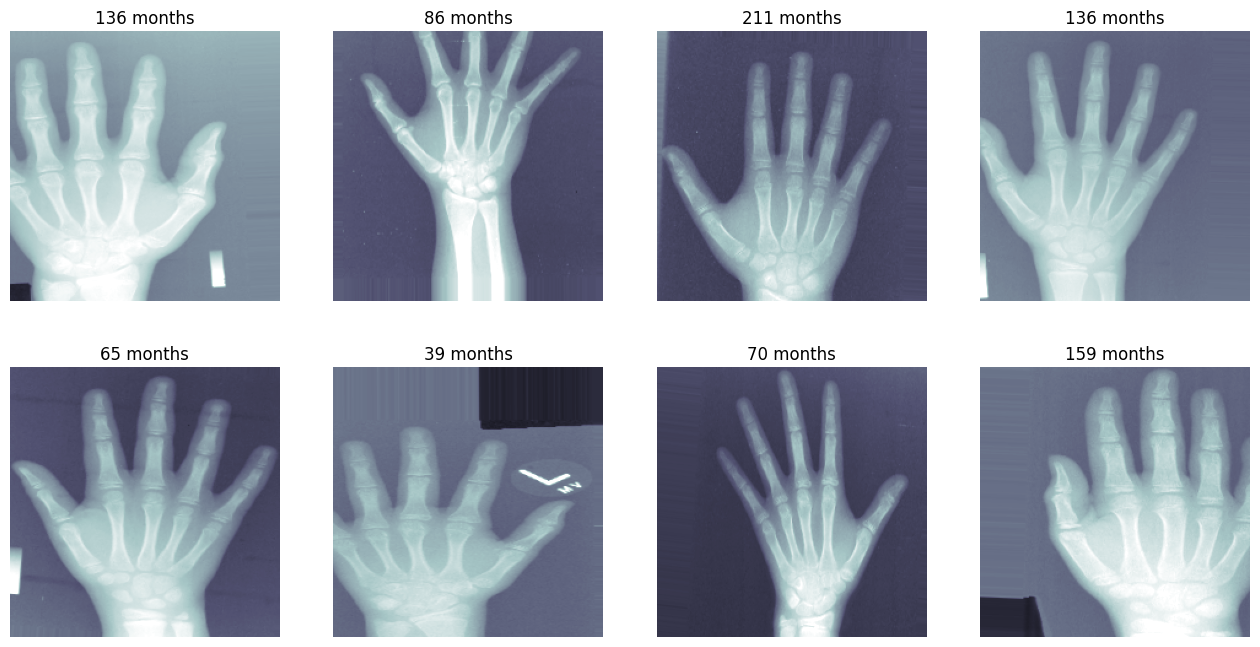

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%2.0f months' % (c_y * boneage_mean + boneage_div))
    c_ax.axis('off')

In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model

in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.layers[-1].get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)

from keras.layers import BatchNormalization

bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)

# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(2048, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 64bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])

from keras.metrics import mean_absolute_error

def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])

bone_age_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 6, 6, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 6, 6, 512)   2048        ['vgg16[0][0]']                  
 alization)                                                                                       
                             

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
bone_age_model.fit_generator(train_gen, 
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

<ipython-input-16-7db53f030617>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  bone_age_model.fit_generator(train_gen,


Epoch 1/5
35/35 [==============================] - ETA: 0s - loss: 0.9849 - mae_months: 91.3231 
Epoch 1: val_loss improved from inf to 0.94104, saving model to bone_age_weights.best.hdf5
35/35 [==============================] - 745s 21s/step - loss: 0.9849 - mae_months: 91.3231 - val_loss: 0.9410 - val_mae_months: 88.9501 - lr: 0.0010
Epoch 2/5
35/35 [==============================] - ETA: 0s - loss: 0.6103 - mae_months: 72.1743 
Epoch 2: val_loss improved from 0.94104 to 0.37864, saving model to bone_age_weights.best.hdf5
35/35 [==============================] - 630s 18s/step - loss: 0.6103 - mae_months: 72.1743 - val_loss: 0.3786 - val_mae_months: 58.3574 - lr: 0.0010
Epoch 3/5
35/35 [==============================] - ETA: 0s - loss: 0.3943 - mae_months: 58.0083 
Epoch 3: val_loss improved from 0.37864 to 0.31942, saving model to bone_age_weights.best.hdf5
35/35 [==============================] - 608s 17s/step - loss: 0.3943 - mae_months: 58.0083 - val_loss: 0.3194 - val_mae_months:

In [17]:
# load the best version of the model
bone_age_model.load_weights(weight_path)

In [18]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in bone_age_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [19]:
print(bone_age_model.layers[-1].get_input_at(0)[-1]);

KerasTensor(type_spec=TensorSpec(shape=(2048,), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [20]:
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 32, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

9/9 [==============================] - 133s 13s/step


Text(0, 0.5, 'Predicted Age (Months)')

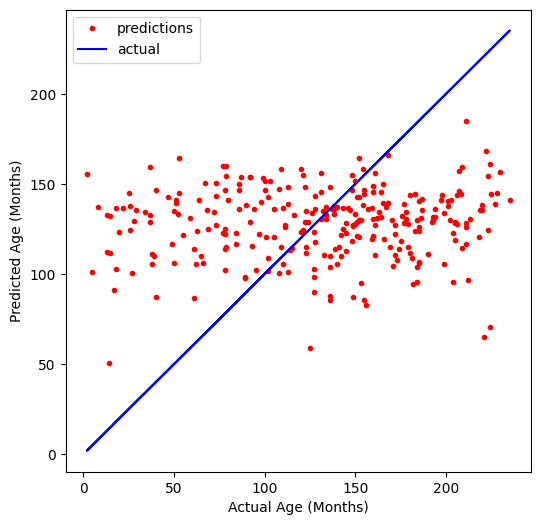

In [21]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [22]:
ord_idx = np.argsort(test_Y)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

Output hidden; open in https://colab.research.google.com to view.

**END**